In [1]:

import os, sys

import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import polars as pl
import dask.array as da
from tqdm import tqdm
from utils.mmap_dataset import MMapIndexedDataset

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import numpy as np
from toolz.functoolz import pipe, compose, curry, flip
from toolz.dicttoolz import valmap
from numba import guvectorize
import coconut

from utils.dask import load_chunk, mmap_dask_array
from utils.distances import levenshtein_distance

(array([ 2.,  3.,  7.,  7., 10., 13., 17., 25., 34., 37., 62., 59., 74.,
        75., 86., 74., 90., 70., 63., 53., 38., 29., 22., 17., 10.,  8.,
        11.,  0.,  1.,  3.]),
 array([-3.04005076e+00, -2.83735179e+00, -2.63465282e+00, -2.43195385e+00,
        -2.22925488e+00, -2.02655591e+00, -1.82385693e+00, -1.62115796e+00,
        -1.41845899e+00, -1.21576002e+00, -1.01306105e+00, -8.10362077e-01,
        -6.07663105e-01, -4.04964134e-01, -2.02265162e-01,  4.33809493e-04,
         2.03132781e-01,  4.05831753e-01,  6.08530724e-01,  8.11229696e-01,
         1.01392867e+00,  1.21662764e+00,  1.41932661e+00,  1.62202558e+00,
         1.82472455e+00,  2.02742352e+00,  2.23012250e+00,  2.43282147e+00,
         2.63552044e+00,  2.83821941e+00,  3.04091838e+00]),
 <BarContainer object of 30 artists>)

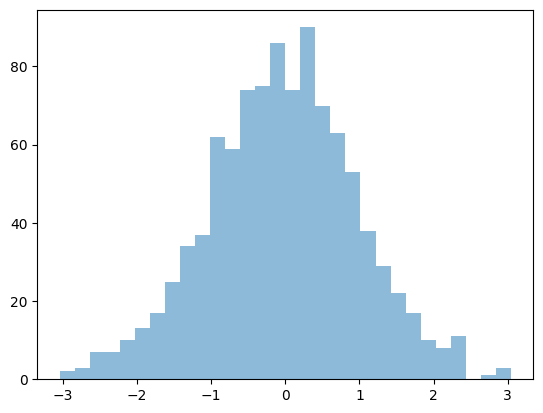

In [2]:
from matplotlib.font_manager import fontManager, FontProperties

path = "helvetica.ttf"
fontManager.addfont(path)

# prop = FontProperties(fname=path)
# sns.set(font=prop.get_name())
plt.hist(np.random.randn(1000), bins=30, alpha=0.5)

In [3]:
from matplotlib.font_manager import fontManager, FontProperties

path = "helvetica.ttf"
fontManager.addfont(path)

# prop = FontProperties(fname=path)
# sns.set(font=prop.get_name())

from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib
plt.rcParams['font.size']=20.
plt.rcParams['axes.labelsize']=20.
plt.rcParams['axes.titlesize']=22.
plt.rcParams['legend.fontsize']=18.
plt.rcParams['savefig.dpi']=1000
plt.rcParams['xtick.labelsize']=17.
plt.rcParams['ytick.labelsize']=17.
plt.rcParams['xtick.minor.size']=3
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.minor.size']=3
plt.rcParams['ytick.major.size']=5
plt.rcParams['xtick.major.width']=1.
plt.rcParams['xtick.minor.width']=1.
plt.rcParams['ytick.major.width']=1.
plt.rcParams['ytick.minor.width']=1.
plt.rcParams['axes.linewidth']=2.
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.constrained_layout.use'] = True

In [4]:
df = pd.read_parquet('../results/deduped/analysis.parquet.gzip')

In [5]:
from collections import defaultdict
def unpack_data(fname):
    data = defaultdict(list)
    for i in range(16):
        f = np.load(fname.format(i))
        for k in f.keys():
            data[k].append(f[k])
    res = {}
    res["results"] = np.transpose(np.concatenate(data["results"], axis=1), (1, 0, 2))
    res["indices"] = np.concatenate(data["indices"])
    
    res["gt"] = np.concatenate(data["data"])
    res["orig"] = np.concatenate(data["gen_orig"])
    return res
indices_0_1 = (pipe(df,
         lambda x: x[x.index.get_level_values(1) != 10000],
         lambda x: x.groupby(x.index.get_level_values(0)).min()["lev"] < 10) & 
       pipe(df,
            lambda x: x[x.index.get_level_values(1) == 10000],
            lambda x: (x["lev"] >= 40) & (x["complexity"] > 0.8),
            ) 
            # & pipe(df, lambda x: x.groupby(x.index.get_level_values(0)).min()["cumsum30"] == 1)
        )

process = compose(
    lambda d:
                  valmap(lambda x: x[np.array(list(map(lambda x: x in indices_0_1[indices_0_1].index, d["indices"])))], d),
                 unpack_data)
data = {"10k_0_1": process("../results/deduped/sample_0_1/10000_{}.npz"),
        "10k_0_5": process("../results/deduped/sample_0_5/10000_{}.npz"),
        "10k_1_0": process("../results/deduped/sample_1_0/10000_{}.npz"),
        "10k_2_0": process("../results/deduped/sample_2_0/10000_{}.npz")
        # "19k": process("../results/mem_once/perturb/19000_{}.npz"),
       }

In [6]:
dists = valmap(lambda x: np.array(list(map(
    flip(curry(levenshtein_distance))(
    x["gt"][:, 32:96]), 
    tqdm(x["results"][:, :, 32:96].transpose(1, 0, 2))))), data)
dists_orig = valmap(lambda x: levenshtein_distance(x["orig"][:, 32:96], x["gt"][:, 32:96]), data)

100%|██████████| 200/200 [00:01<00:00, 167.00it/s]


In [7]:

plt.rcParams['font.size']=20.
plt.rcParams['axes.labelsize']=20.
plt.rcParams['axes.titlesize']=22.
plt.rcParams['legend.fontsize']=18.
plt.rcParams['savefig.dpi']=1000
plt.rcParams['xtick.labelsize']=17.
plt.rcParams['ytick.labelsize']=17.
plt.rcParams['xtick.minor.size']=3
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.minor.size']=3
plt.rcParams['ytick.major.size']=5
plt.rcParams['xtick.major.width']=1.
plt.rcParams['xtick.minor.width']=1.
plt.rcParams['ytick.major.width']=1.
plt.rcParams['ytick.minor.width']=1.
plt.rcParams['axes.linewidth']=2.
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.constrained_layout.use'] = True

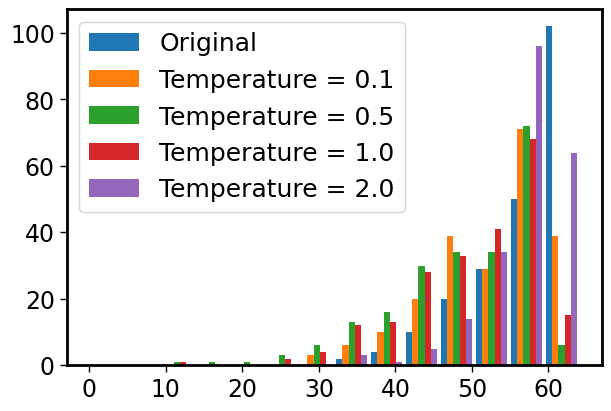

In [12]:
f, ax = plt.subplots(figsize=(6, 4))

n, bins, patches = ax.hist([
    dists_orig["10k_0_1"],
    np.min(dists["10k_0_1"], axis=0),
    np.min(dists["10k_0_5"], axis=0),
    np.min(dists["10k_1_0"], axis=0),
    np.min(dists["10k_2_0"], axis=0),
], 
    bins=np.linspace(0, 64, 15),
    label=["Original", "Temperature = 0.1", "Temperature = 0.5", "Temperature = 1.0", "Temperature = 2.0"],
    rwidth=0.9,
)


# ax[0].legend()
ax.legend()
f.savefig("../figures/perturb_10k_lowtemp.pdf")

In [27]:
# CLOSEST MATCH OF LATENT VS FUTURE TRAINING

(array([  1.,   0.,   0.,   0.,   0.,  26., 138., 122., 126., 102.]),
 array([ 6. , 11.8, 17.6, 23.4, 29.2, 35. , 40.8, 46.6, 52.4, 58.2, 64. ]),
 <BarContainer object of 10 artists>)

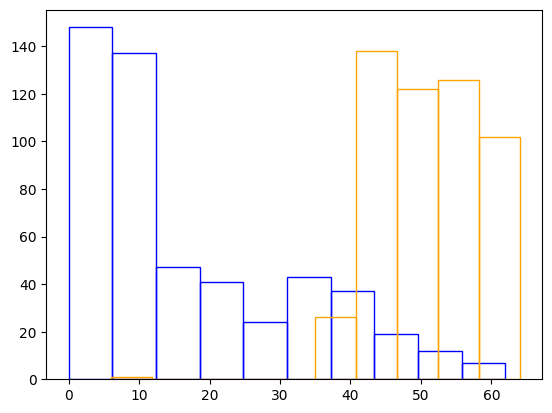

In [9]:
plt.hist(np.min(dists, 0), fill=False, edgecolor='blue')
plt.hist(dist_orig, fill=False, edgecolor='orange')

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="/om/user/sunnyd/transformers_cache",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [98]:
tokenizer.decode(res[7,4, 32:96])


'01 build #kubuntu-devel- Project mgmt_docker Â» swy-01 build #kubuntu-devel- Project mgmt_docker Â» swy-01 build #kubuntu-devel- Project mgmt_docker Â» swy-01 build #kubuntu-devel- Project mgmt_docker Â'

In [91]:
tokenizer.decode(gt[4, 32:96])

'01 build #2834: SUCCESS in 4 min 15 sec: https://kci.pangea.pub/job/mgmt_docker/label=swy-01/2834/\n<IrcsomeBot1> <MichaelTunnell> @acheronuk any news about the'

In [73]:
 - res[1, 0]

ValueError: operands could not be broadcast together with shapes (2049,) (96,) 

(array([2374., 3394., 4979., 8258., 5828., 1232.,  676.,  257.,  126.,
          51.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

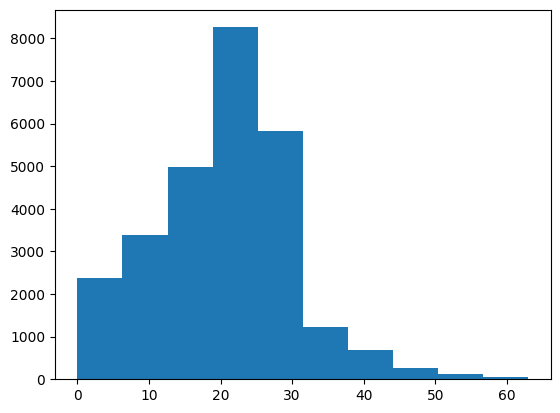

In [64]:
plt.hist(np.min(dists, 0))

In [152]:
dists0 = []
for i in tqdm(range(200)):
    dists0.append(levenshtein_distance(perturb00[i, :, 32:96], gt[:, 32:96]))
dists0 = np.stack(dists0)

100%|██████████| 200/200 [00:02<00:00, 75.36it/s]


In [153]:
# maxvals = df.groupby(df.index.get_level_values(0)).transform('max') 
# minvals = df.groupby(df.index.get_level_values(0)).transform('min') 
# indices_0_1 = np.array(list(set(df[(df["lev"] > 50 ) & (df.index.get_level_values(-1) == 10000)].index.get_level_values(0).to_numpy()).intersection(
#     set(df[(minvals["lev"] < 20) & (maxvals["cumsum30"] < 15)].index.get_level_values(0).to_numpy()))))
# indices_0_0 = np.array(list(set(df[(df["lev"] > 60 ) & (df.index.get_level_values(-1) == 10000)].index.get_level_values(0).to_numpy()).intersection(
#     set(df[minvals["lev"] >= 10].index.get_level_values(0).to_numpy()))))

In [154]:
dists_control = []
for i in tqdm(range(200)):
    dists_control.append(levenshtein_distance(perturb_control[i, :, 32:96], gt_control[:, 32:96]))
dists_control = np.stack(dists_control)

100%|██████████| 200/200 [01:09<00:00,  2.87it/s]


(array([   59.,    39.,    65.,    99.,   113.,   193.,   330.,   769.,
         1952., 11381.]),
 array([ 0. ,  6.4, 12.8, 19.2, 25.6, 32. , 38.4, 44.8, 51.2, 57.6, 64. ]),
 <BarContainer object of 10 artists>)

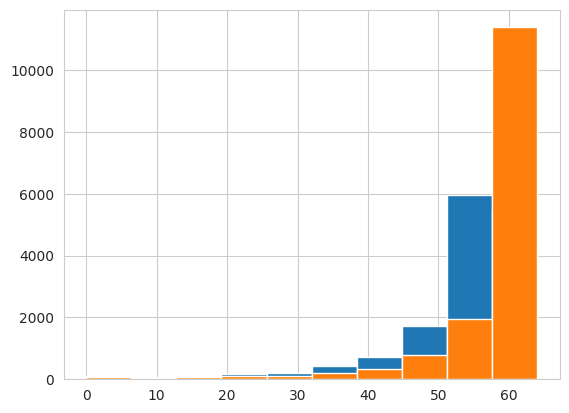

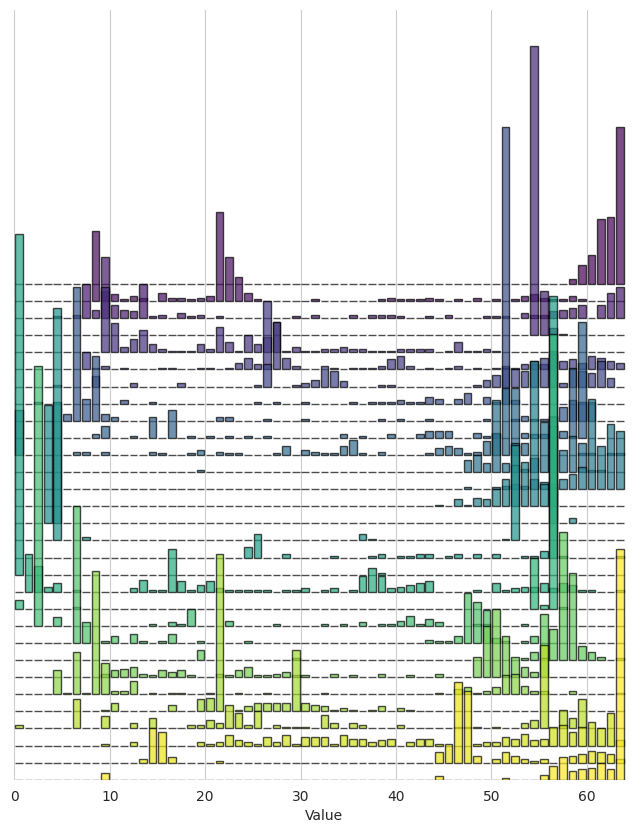

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: 5 different distributions
np.random.seed(0)
data = dists.T[:30, :]

# Create the ridge plot
fig, ax = plt.subplots(figsize=(8, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

# Parameters for controlling the overlap
overlap = 0.7

for i, (color, dist) in enumerate(zip(colors, data)):
    counts, bins = np.histogram(dist, bins=np.arange(0, 65))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_centers, counts/10, alpha=0.7, color=color, edgecolor='k',
           bottom=-i * 1.0+50)

ax.set_yticks([])
ax.set_xlabel('Value')
ax.set_xlim(0, 65)
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(False)
fig.savefig("../figures/perturbation_dist.pdf")


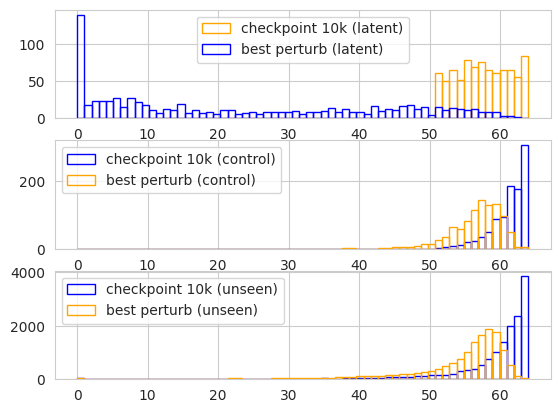

In [167]:
# gen_neg - gt
# perturb00_neg = np.concatenate(perturbs, axis=1)
# indices00_neg = np.concatenate(indices)
# gt00_neg = np.concatenate(gt)
# ori00_neg = np.concatenate(orig)
f, ax = plt.subplots(3, 1)
vals = np.min(dists00, axis=0)
orig_dists00 = levenshtein_distance(gen_neg.detach().cpu().numpy()[:, 32:96], gt00_neg[:, 32:96])
ax[1].hist(orig_dists00, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='blue', fill=False, label='checkpoint 10k (control)')
ax[1].hist(vals, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='orange', fill=False,  label='best perturb (control)')
ax[0].hist(orig_dists, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='orange', fill=False, label='checkpoint 10k (latent)')
ax[0].hist(vals0, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='blue', fill=False, label='best perturb (latent)')

dist_orig_control = levenshtein_distance(orig_control[:, 32:96], gt_control[:, 32:96])
vals_control = np.min(dists_control, axis=0)

ax[2].hist(dist_orig_control, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='blue', fill=False,  label='checkpoint 10k (unseen)')
ax[2].hist(vals_control, bins=np.linspace(0, 64, 64), alpha=1, edgecolor='orange', fill=False, label='best perturb (unseen)')
ax[0].legend()
ax[1].legend()
ax[2].legend()
f.savefig("../figures/10k_control.pdf")

## Old

In [124]:
initial_dists = levenshtein_distance(perturb["gen_orig"], data[:, :288])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Text(0.5, 0, 'minimum levenshtein distance')

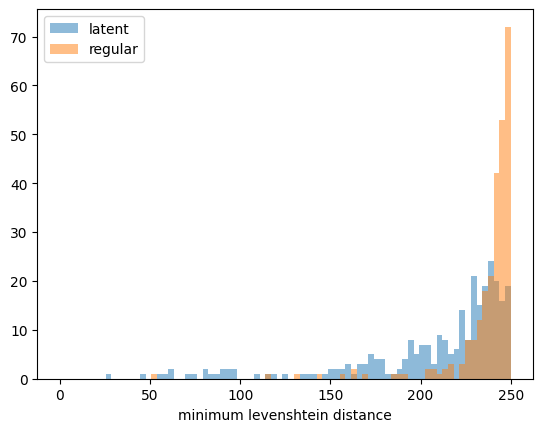

In [29]:
vals = initial_dists
plt.hist(vals[:302], bins=np.linspace(0, 250, 80), alpha=0.5, label='latent')
plt.hist(vals[302:], bins=np.linspace(0, 250, 80), alpha=0.5, label='regular')
plt.legend()
plt.xlabel('minimum levenshtein distance')

Text(0.5, 0, 'minimum levenshtein distance delta')

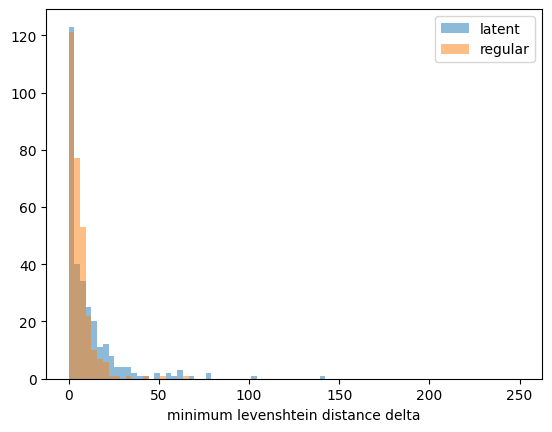

In [33]:
vals = initial_dists - np.min(dists, axis=0)
plt.hist(vals[:302], bins=np.linspace(0, 250, 80), alpha=0.5, label='latent')
plt.hist(vals[302:], bins=np.linspace(0, 250, 80), alpha=0.5, label='regular')
plt.legend()
plt.xlabel('minimum levenshtein distance delta')

In [84]:
perturb["gen_orig"][5]

array([  253,  4156, 48324,  2900,  2529,   407,   253,  1386,  3284,
        1764,  1968,    92, 14456,  3837,    52,    94,   187,    61,
        2009,    92,    72,    94,   426,   428,    71,     9,    83,
          10,  7064,    63,    19,  2766,  1124,    92,    18,  1217,
          71,     9,    83,  3117,  5267,    63,    19,    12,    83,
          63,    19,    69,    61,  4153,    63,    19, 11227,   835,
         370,    71,     9,    83,  1009,   310,   253, 48324, 16841,
        1159,    15,   380,  7982,   370,    72,     5,   310,  1677,
         407,   253, 48324, 16841,  1159,   370,    51,     9,    83,
        1009,   285,   253,  7982,   370,    72,     5,   310,  1677,
         407,   253, 48324, 16841,  1159,   370,    51,     9,    83,
        4010,    51,     9,    83,    13,    17,  3822,   380,  7982,
         370,    72,     5,   310,   247,  2900,   273,   253, 21003,
          14,  9684,  4714,  7424,  1764,  1968,    92, 48987,    14,
        9684,  4714,

In [81]:
np.argwhere(dists[:, 5] == 0)

array([[ 43],
       [193]])

In [87]:
res1 = np.max(np.sum(perturb["results"] == perturb["gen_orig"], -1), 0)[:302]
res0 = np.max(np.sum(perturb["results"] == perturb["gen_orig"], -1), 0)[302:]

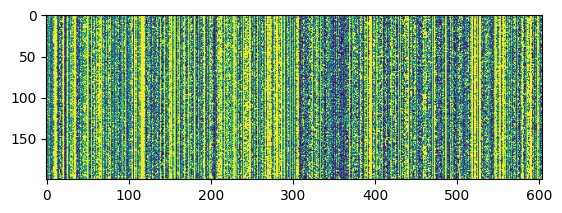

In [28]:
plt.imshow(np.sum(perturb["results"] == perturb["gen_orig"], -1))

In [91]:
res1
res0

array([288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 133, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
       288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 28

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,   5.10204082,  10.20408163,  15.30612245,
         20.40816327,  25.51020408,  30.6122449 ,  35.71428571,
         40.81632653,  45.91836735,  51.02040816,  56.12244898,
         61.2244898 ,  66.32653061,  71.42857143,  76.53061224,
         81.63265306,  86.73469388,  91.83673469,  96.93877551,
        102.04081633, 107.14285714, 112.24489796, 117.34693878,
        122.44897959, 127.55102041, 132.65306122, 137.75510204,
        142.85714286, 147.95918367, 153.06122449, 158.16326531,
        163.26530612, 168.36734694, 173.46938776, 178.57142857,
        183.67346939, 188.7755102 , 193.87755102, 198.97959184,
        204.08163265, 209.18367347, 214.28571429, 219.3877551 ,
        224.48979592, 229.59183673, 234.69387755, 239.79591837,
        24

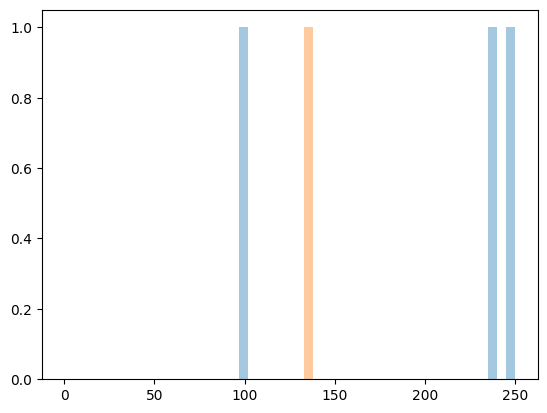

In [88]:
plt.hist(res1, bins=np.linspace(0, 250, 50), alpha=0.4)
plt.hist(res0, bins=np.linspace(0, 250, 50), alpha=0.4)
